In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pycox.models import LogisticHazard
from sklearn.model_selection import train_test_split
from pycox.evaluation import EvalSurv
import numpy as np
import wandb
from pycox.models.loss import NLLLogistiHazardLoss
from rna.encoder import RNAEncoder
from sklearn.model_selection import StratifiedKFold

In [15]:
torch.cuda.is_available()

True

In [16]:
dataset_path1 ='../data/dataset_only_rna.csv'
dataset_path2 ='../data/dataset.csv'

In [17]:
root_path ='../../..'

In [24]:
dataset1=pd.read_csv(dataset_path1)
dataset=pd.read_csv(dataset_path2)

In [25]:
dataset1.iloc[0, :]['RNA']

'/DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-40d2-b099-acf15dead7c7/013c0ba5-0d5e-467a-b9cc-4e19f75e21d6.rna_seq.augmented_star_gene_counts.csv'

In [26]:
dataset1.iloc[0, :]['RNA']

'/DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-40d2-b099-acf15dead7c7/013c0ba5-0d5e-467a-b9cc-4e19f75e21d6.rna_seq.augmented_star_gene_counts.csv'

In [27]:
dataset=pd.read_csv(dataset_path2)
# del dataset['Unnamed: 0']
dataset['RNA'] =dataset['RNA'].str.replace("../..", "")
dataset.to_csv("../data/dataset.csv", index=False)

In [21]:
dataset=pd.read_csv(dataset_path)

In [7]:
train_brain = dataset[dataset.group == 'train']
test_brain = dataset[dataset.group == 'test']

In [8]:
train_brain

,submitter_id,tumor_stage,age_at_diagnosis,prior_treatment,prior_malignancy,synchronous_malignancy,days_to_last_follow_up,gender,race,vital_status,...,IDH,MGMT,X1p19q,19.20.gain,7g10l,TERT,ATRX,DNAm,RNA,splits
0,TCGA-CS-4938,NaN,11509.0,No,no,No,3574.0,female,white,Alive,...,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/a282f56a-0884-40d2-...,0.0
1,TCGA-CS-4941,NaN,24578.0,No,no,No,NaN,male,white,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/20443648-a8c8-41ef-...,1.0
2,TCGA-CS-4942,NaN,16297.0,No,no,No,NaN,female,black or african american,Dead,...,Mutant,Unmethylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/81c11217-7d87-49a6-...,4.0
3,TCGA-CS-4943,NaN,13565.0,No,no,No,NaN,male,white,Dead,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Not expressed,Mutant,NaN,/DRIM/data/TCGA/GBMLGG/RNA/bb459bb7-ff32-431d-...,0.0
4,TCGA-CS-4944,NaN,18494.0,No,no,No,1828.0,male,white,Alive,...,Mutant,Methylated,non-codel,No chr 19/20 gain,No combined CNA,Expressed,WT,NaN,/DRIM/data/TCGA/GBMLGG/RNA/ddda9728-45af-4d0b-...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,TCGA-81-5911,NaN,12292.0,No,NaN,NaN,539.0,male,white,Alive,...,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN,2.0
882,TCGA-OX-A56R,NaN,25178.0,No,no,No,NaN,male,black or african american,Dead,...,WT,Methylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN,4.0
883,TCGA-RR-A6KA,NaN,26582.0,No,no,No,NaN,female,black or african american,Dead,...,WT,Methylated,non-codel,Gain chr 19/20,No combined CNA,NaN,WT,NaN,NaN,2.0
884,TCGA-RR-A6KB,NaN,18713.0,No,no,No,0.0,male,black or african american,Alive,...,WT,Unmethylated,non-codel,No chr 19/20 gain,Gain chr 7 & loss chr 10,NaN,WT,NaN,NaN,0.0


In [9]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
# splits = np.zeros(len(train_brain))
# for i, (_, fold_idx) in enumerate(skf.split(train_brain, train_brain.project_id)):
#     splits[fold_idx] = i

In [10]:
# train_brain['splits'] =splits

In [11]:
# train_brain.loc[train_brain['RNA'].notnull()]['splits'].value_counts()

In [12]:
#pd.concat([train_brain, test_brain]).to_csv("../data/dataset.csv", index=False)

In [13]:
class RNADataset(Dataset):
    """RNA dataset."""

    def __init__(self, data, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to RNA csv files
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
       
        sample_path =self.data.iloc[idx]['RNA']
        
        sample =pd.read_csv(self.root_dir+sample_path)["fpkm_uq_unstranded"].values.reshape(1, -1)
        
        return torch.from_numpy(sample)

In [14]:
class RNASurvivalDataset(RNADataset):
    """RNA dataset."""

    def __init__(self, data,root_dir, times, events):
        super().__init__(data, root_dir)
        self.times =times
        self.events =events


    def __getitem__(self, idx):
        
        sample =super().__getitem__(idx)
        return sample.float(), self.times[idx],self.events[idx]

In [15]:
dataset =dataset.loc[dataset.RNA.notnull()]
dataset_test =dataset.loc[dataset.group =='test']
dataset_train =dataset.loc[dataset.group =='train']
dataset_train, dataset_val =train_test_split(dataset_train, test_size =0.2)
dataset_train=dataset_train.reset_index(drop=True)
dataset_val=dataset_val.reset_index(drop=True)

In [16]:
dataframes = {"train" : dataset_train, "val" : dataset_val, "test" : dataset_test}

In [17]:
datasets, dataloaders = {}, {}
events, times ={}, {}
n_intervals = 20
for split, dataframe in dataframes.items():
    if split =="train":
        labtrans = LogisticHazard.label_transform(n_intervals)
        labtrans.fit(dataframe['time'], dataframe['event'])
    events[split], times[split] =labtrans.transform(dataframe['time'], dataframe['event'])
    datasets[split] = RNASurvivalDataset(dataframe, root_path, events[split],times[split])
    if split =='train':
        dataloaders[split] =DataLoader(datasets[split],shuffle=True, batch_size=24)
    else:
        dataloaders[split] =DataLoader(datasets[split],shuffle=False, batch_size=1)

In [18]:
data =[] 
for batch in dataloaders['train']:
    data.append(batch[0].cpu().numpy()[:,0,:])

In [19]:
data =np.concatenate(data)

In [20]:
pd.read_csv(root_path+dataset_train.iloc[0,:]['RNA'])

,gene_id,fpkm_uq_unstranded
0,ENSG00000000003.15,22.9291
1,ENSG00000000005.6,0.0288
2,ENSG00000000419.13,17.8829
3,ENSG00000000457.14,1.7566
4,ENSG00000000460.17,0.9449
...,...,...
16299,ENSG00000287908.1,0.1303
16300,ENSG00000288558.2,1.6724
16301,ENSG00000288611.1,0.0152
16302,ENSG00000288658.1,0.1076


In [21]:
data.max()

65532.855

from matplotlib import pyplot as plt

In [22]:
from matplotlib import pyplot as plt

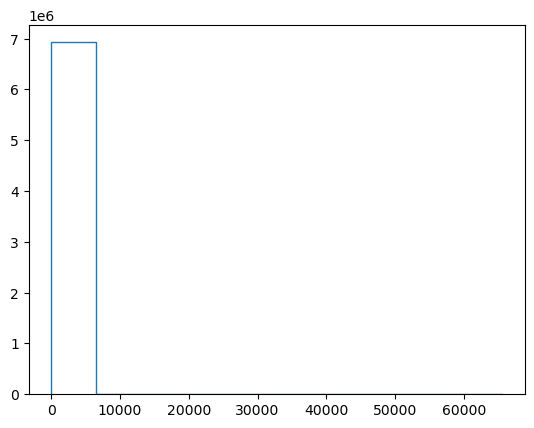

In [23]:
counts, bins = np.histogram(data.flatten())
plt.stairs(counts, bins)

In [38]:
data.flatten().min()

0.0

In [39]:
data.flatten().max()

65532.855

In [40]:
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [41]:
def log_transform(x):
    # print(x.shape)
    return np.log(x + 1)


scaler = StandardScaler()
log = FunctionTransformer(log_transform)
pipe = Pipeline(steps=[
                        ('log', log) ,
                       ('scaler', scaler)
                      ])
pipe.fit(data)

Pipeline(steps=[('log',
                 FunctionTransformer(func=<function log_transform at 0x7f57f1088b80>)),
                ('scaler', StandardScaler())])

In [42]:
data_scaled =pipe.transform(data)

In [43]:
data_scaled.max()

20.586178

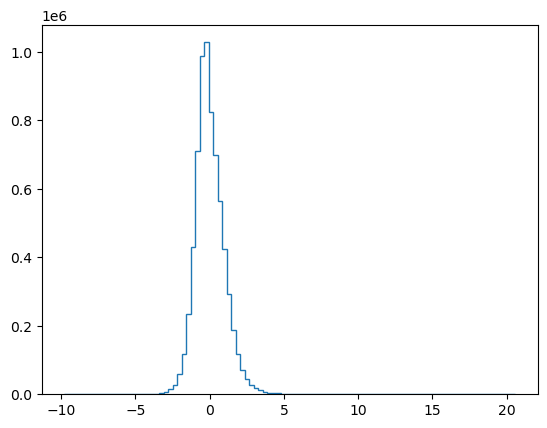

In [46]:
counts, bins = np.histogram(data_scaled.flatten(),bins=100)
plt.stairs(counts, bins)

In [45]:
scaler ={"mean_values" :list(pipe['scaler'].mean_), "scale_" :list(pipe['scaler'].scale_)}

In [64]:
scaler

{'mean_values': [2.749179225248449,
  0.1506125078043517,
  3.002066298653098,
  0.9810900267432717,
  0.6376609037202947,
  1.3282233602159164,
  1.0589042808378444,
  2.0734009979051704,
  2.118036481773152,
  2.109287633334889,
  0.5317954842647648,
  1.891723019656013,
  1.741128698236802,
  2.0509768642397486,
  0.792804836806129,
  0.279084501821986,
  2.9743769143609438,
  0.7338722925830413,
  0.8370230117264916,
  1.4728714920492734,
  2.257857979325687,
  3.391067485809326,
  4.17776083946228,
  1.1431498767786166,
  0.20167231818989795,
  0.6195530200552415,
  3.2369851723839256,
  2.1632516333636116,
  2.024716833409141,
  2.7032014670091518,
  1.4633008553701288,
  0.7693125329298132,
  1.174490773747949,
  1.9389650635859546,
  1.645733436416177,
  0.615694501785671,
  1.2055650455811444,
  0.8073013856656411,
  1.394132946659537,
  2.277568951775046,
  0.8097631669219802,
  1.3651512390725753,
  3.94884669416091,
  0.9583905553116517,
  3.8849381575864905,
  2.3830231862

In [65]:
data_sc =data_scaled - scaler['mean_values']

In [66]:
data_sc =  data_scaled / scaler['scale_']

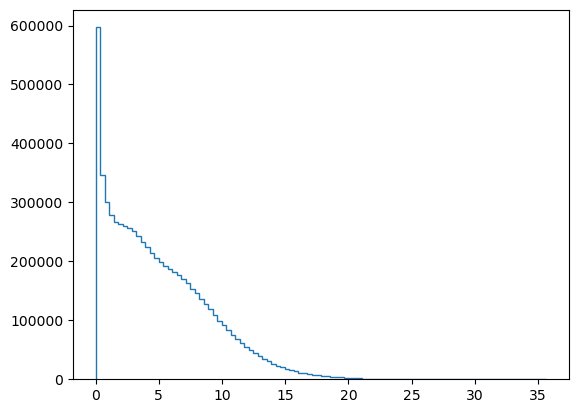

In [68]:
counts, bins = np.histogram(data_sc.flatten(),bins=100)
plt.stairs(counts, bins)

In [56]:
import json
with open('scaler_data.json', 'w') as f:
    json.dump(scaler, f)

In [35]:
data_scaled.max()

20.59126

In [119]:
import seaborn as sns

In [ ]:
data_scaled_cor =pd.DataFrame(data_scaled).corr()

In [ ]:
data_scaled_cor.mean().mean()

In [ ]:
data_scaled_cor.values.std()

In [ ]:
counts, bins = np.histogram(data_scaled_cor.values.flatten(),bins=100)
plt.stairs(counts, bins)

In [ ]:
sns.clustermap(data_scaled_cor.iloc[:100, :100])

In [ ]:
sns.heatmap(data_scaled_cor.iloc[100:200, 100:200],
            xticklabels=data_scaled_cor.columns[100:200].values,
            yticklabels=data_scaled_cor.columns[100:200].values)